# PRAD OS survival Mich

Link to publication : 

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
library(survival)
library(survminer)
library(ggplot2)
library(survcomp)

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: prodlim



## Functions

In [3]:
# Modify the OS status to match the common convention
modifyOSStatus = function(x){
    status = unlist(strsplit(x, split = ":"))[1]
    return(status)
}

# Add patient id from sample clin data
addPatientId = function(exp.data, sample.clin.data){
    sample.clin.data.minimal = sample.clin.data %>% dplyr::select(PATIENT_ID, SAMPLE_ID)
    sample.clin.data.minimal$Sample = sample.clin.data.minimal$SAMPLE_ID
    sample.clin.data.minimal = sample.clin.data.minimal %>% dplyr::select(-SAMPLE_ID)
    exp.data =  dplyr::left_join(exp.data, 
                                 sample.clin.data.minimal, by = "Sample")
    return(exp.data)
}

# Add survival data from patient clin data 
addSurvivalData = function(exp.data, patient.clin.data){
    patient.clin.data.minimal = patient.clin.data %>% dplyr::select(PATIENT_ID, OS, OS.time)
    exp.data =  dplyr::left_join(exp.data, 
                                 patient.clin.data.minimal, by = "PATIENT_ID")

}

# 
# Function fits a cox regression model
# 
fitCoxModel = function(data, end.point, features){
    
    end_point_event = end.point
    end_point_time = paste0(end.point, ".time")
    
    # Generate a survival formula object 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, paste(features, collapse = " + "), sep = " ~ "))
    
    model.fit = coxph(f, data = data)
    return(model.fit)
}

#
# Plot Kaplan-Meier curve by relative risk
#
plotKMbyRelativeRisk = function(data, rel.risk) {

    # Assign relative risk 
    data$pred <- rel.risk
    data$group <- ifelse(data$pred  < median(data$pred), "Low", "High")

    if (length(table(data$group)) == 2) {

        # Fit the survival function 
        s.fit.train <- survfit(Surv(time, status) ~group, data = data)

        # Generate the formula for the model 
        survExpression = paste0("Surv(", "time", ", " , "status", ")")
        f <- as.formula(paste(survExpression, "group", sep = " ~ "))
        sFit <- surv_fit(f, data =  data)

        # Initialise results object 
        sFit.res = list()

        # Prepare plot  
        sFit.res$Plot <- ggsurvplot(s.fit.train, 
                           data = data, legend = "bottom",
                           title = paste0("Risk groups", " (n = ", nrow(data) ,")"),
                           legend.title = "Risk group", pval = TRUE, xlab = "Time (days)", 
                          font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                           tables.theme = theme_survminer())
   

        # Store relevant information as table 
        sFit.res$table = data.frame(N = nrow(data), 
                                Pvalue = surv_pvalue(sFit))

    } else {
        # Based on the predicted risk it was impossible to group into two groups
        # we cannot get a p-value 
        sFit.res = NULL
    } 
    return(sFit.res)
}

## Load and preprocess data

In [4]:
data.dir = "/workstation//project_data/landstrom_project_3/prad_mich/"

### Clinical patient data

In [5]:
# Clinical data for patients 
clinical.patients = read.csv(file.path(data.dir, "data_clinical_patient.csv"), sep = "\t")

# Remove all patients without OS_STATUS
clinical.patients = clinical.patients[clinical.patients$OS_STATUS != "",]

# Modify the OS_Status
clinical.patients$OS = as.numeric(unlist(map(clinical.patients$OS_STATUS, modifyOSStatus)))
clinical.patients$OS.time =  clinical.patients$OS_MONTHS

# Remove patients without overal survival time
clinical.patients = clinical.patients[!is.na(clinical.patients$OS.time),]

### Clinical sample data

In [6]:
# Clinical data for patients 
clinical.samples = read.csv(file.path(data.dir, "data_clinical_sample.csv"), sep = "\t")

# Select only samples from patients with OS status
clinical.samples = dplyr::filter(clinical.samples, PATIENT_ID %in% clinical.patients$PATIENT_ID)

In [7]:
sample.counts.per.patient = as.data.frame(table(clinical.samples$PATIENT_ID))

In [8]:
colnames(sample.counts.per.patient) = c("PATIENT_ID", "FREQ")
sample.counts.per.patient = arrange(sample.counts.per.patient, desc(FREQ))

Keep track of the patients with multiple samples. We need to deal with this somehow later.

In [9]:
patients.with.multi = sample.counts.per.patient$PATIENT_ID[sample.counts.per.patient$FREQ > 1]

In [10]:
patients.with.multi

[1] WA43
48 Levels: WA10 WA11 WA12 WA13 WA14 WA15 WA16 WA17 WA18 WA19 WA20 WA22 ... WA7

### Expression data

In [11]:
# Capture data 
expression.data.rpkm = read.csv(file.path(data.dir, "data_mrna_seq_rpkm_zscores_ref_diploid_samples.csv"), 
                                   sep = "\t", check.names = F)

In [12]:
# Select samples included in the clinical.samples 
expression.data.rpkm = expression.data.rpkm[,colnames(expression.data.rpkm) %in% c("Hugo_Symbol", clinical.samples$SAMPLE_ID)]

In [13]:
dim(expression.data.rpkm)

[1] 20709    32

## Merge the expression data and clinical data 

First transpose the expression tables

In [14]:
expression.data.rpkm.long = expression.data.rpkm %>% pivot_longer(-Hugo_Symbol, 
                                 values_to = "Expression", 
                                 names_to = "Sample")

expression.data.rpkm.wider = expression.data.rpkm.long %>% 
                               pivot_wider(names_from = Hugo_Symbol,
                                           values_from =  Expression,
                                           values_fn = ~mean(.x, na.rm = TRUE))  

colnames(expression.data.rpkm.wider)[2:ncol(expression.data.rpkm.wider)] = paste0(colnames(expression.data.rpkm.wider)[2:ncol(expression.data.rpkm.wider)], ".exp")


In [15]:
# Add patient ids for samples 
expression.data.rpkm.with.patid = addPatientId(expression.data.rpkm.wider, clinical.samples)

In [16]:
# Add survival data from patient clin data
expression.data.rpkm.final = addSurvivalData(expression.data.rpkm.with.patid, clinical.patients)

## Run univariate feature analysis for pre-filtering features 

In [18]:
# Gene list  
gene.list.file = read.table("/workstation/project_data/landstrom_project_3/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

In [19]:
expression.data.rpkm.final.goi = expression.data.rpkm.final %>% select(one_of(paste0(gene.list, ".exp")), OS, OS.time)

In [21]:
#
# Main function
#
plotKMexp = function(variable,
                     training_data,
                     end_point_event,
                     end_point_time,
                     plot_title,
                     life.table = T){
  
  # Subset training data by variables 
  trainingDataFinal =  training_data %>% 
    dplyr::select(all_of(c(variable, end_point_event,  end_point_time)))

  
  # Calculate median expression 
  medianExpression = median(trainingDataFinal[[variable]])
  
  # Divide into two groups 
  group = ifelse(trainingDataFinal[[variable]] > medianExpression, "High", "Low")
  
  # Add as variable 
  trainingDataFinal$group = group
  
  # Generate the formula for the model 
  survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
  f <- as.formula(paste(survExpression, "group", sep = " ~ "))
  sFit <- surv_fit(f, data =  trainingDataFinal)
 
  # Store plot and p-value 
  sFit.res = list()

  # Prepare KM
  if (life.table == T) {
    sFit.res$Plot <- ggsurvplot(sFit, 
                           data = trainingDataFinal, legend = "bottom",
                           title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                           legend.title = "Expression group", pval = TRUE, xlab = "Time (days)", 
                           font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                           tables.theme = theme_survminer())
  } else {
    sFit.res$Plot <- ggsurvplot(sFit, 
                           data = trainingDataFinal, legend = "none",
                           title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                           legend.title = "Expression group", pval = TRUE, xlab = "Time (days)", 
                           font.family = "Helvetica", font.x = 10, font.y = 10, font.tickslab = 10, font.legend = 8,
                           conf.int = T,
                           break.time.by = 10,
                           surv.plot.height = 0.65, risk.table = FALSE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 5)
  }

  # Get p-value 
  sFit.res$Pval = surv_pvalue(sFit)
  
  return(sFit.res)
  
}

In [22]:
runUnivariateKM = function(input.data, 
                           variables,
                           clinical.endpoint,
                           plots){

    # Storing results 
    results.plots = list()
    results.tables = list()

    # Iterate over variables
    for (var in variables) {
        
        
        results = plotKMexp(variable = var, 
                            training_data = input.data,
                            end_point_event = clinical.endpoint,
                            end_point_time = paste0(clinical.endpoint, ".time"),
                            plot_title = "Full cohort")

        results.plots[[var]] = results$Plot
        results.tables[[var]] = results$Pval
    }
    return(list(results.plots, results.tables))
}

In [23]:
# Run univariate KM
km.results = runUnivariateKM(input.data = expression.data.rpkm.final.goi, 
                                  variables = paste0(gene.list, ".exp") ,
                                  clinical.endpoint = "OS",
                                  plots = T)

In [28]:
km.results.table = bind_rows(km.results[[2]], .id = "Feature")

In [29]:
km.results.table  %>% arrange(pval)

Feature,variable,pval,method,pval.txt
<chr>,<chr>,<dbl>,<chr>,<chr>
PTEN.exp,group,0.07602816,Log-rank,p = 0.076
VPS4B.exp,group,0.13742083,Log-rank,p = 0.14
MYC.exp,group,0.24092131,Log-rank,p = 0.24
APPL1.exp,group,0.27741803,Log-rank,p = 0.28
VPS4A.exp,group,0.31841902,Log-rank,p = 0.32
TGFBR1.exp,group,0.49682305,Log-rank,p = 0.5
AURKB.exp,group,0.50361136,Log-rank,p = 0.5
KIF23.exp,group,0.60287181,Log-rank,p = 0.6
AURKA.exp,group,0.61005608,Log-rank,p = 0.61


## Fit the Cox-model including the model genes

#### P-value threshold 0.1

In [32]:
cox.model.005 = fitCoxModel(expression.data.rpkm.final.goi, 
            end.point = "OS", 
            features = km.results.table$Feature[km.results.table$pval < 0.1])

In [33]:
cox.model.005

Call:
coxph(formula = f, data = data)

           coef exp(coef) se(coef)     z    p
PTEN.exp 0.1845    1.2027   0.1672 1.103 0.27

Likelihood ratio test=1.24  on 1 df, p=0.2653
n= 31, number of events= 31 

In [34]:
# Predict based on model
rel.risk.005 = predict(object = cox.model.005)

In [35]:
# Prepare data
y.data.005 = expression.data.rpkm.final.goi %>% dplyr::select(OS, OS.time)
colnames(y.data.005) = c("status","time")

In [39]:
# Calculate C-index
cindex.005 = concordance.index(rel.risk.005, 
                                     y.data.005$time, 
                                     y.data.005$status,
                                     na.rm = TRUE)

In [40]:
cindex.005$c.index

[1] 0.5577342

In [41]:
# Plot KM
km.res.005 = plotKMbyRelativeRisk(data = y.data.005, 
                                     rel.risk = rel.risk.005)

$Plot

$table
   N Pvalue.variable Pvalue.pval Pvalue.method Pvalue.pval.txt
1 31           group  0.04317635      Log-rank       p = 0.043


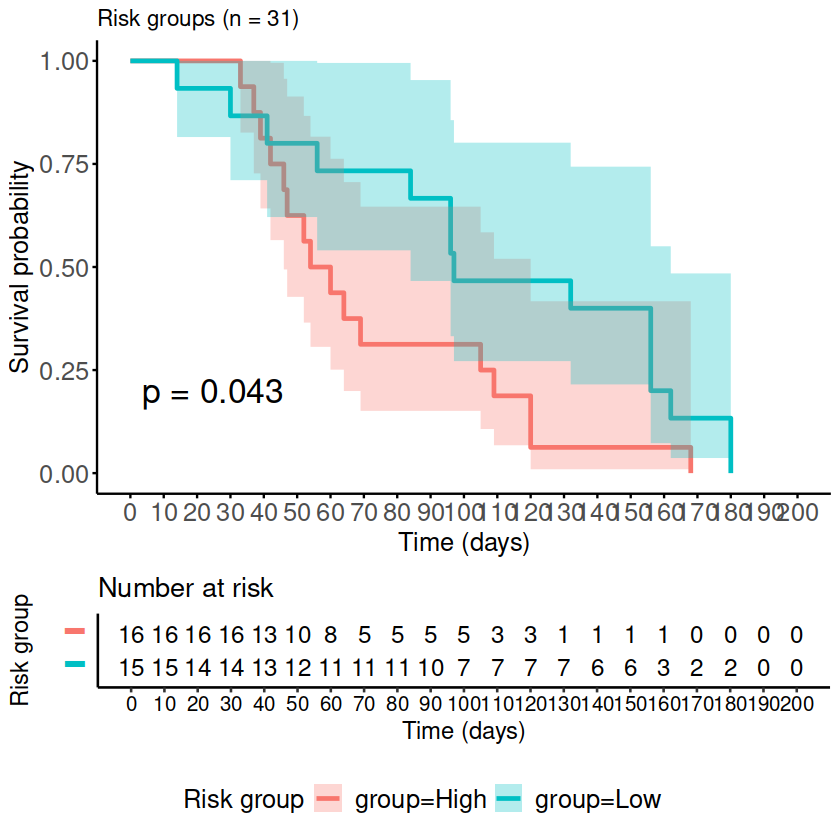

In [42]:
km.res.005

#### P-value threshold 0.2

In [43]:
cox.model.02 = fitCoxModel(expression.data.rpkm.final.goi, 
            end.point = "OS", 
            features = km.results.table$Feature[km.results.table$pval < 0.2])

In [44]:
cox.model.02

Call:
coxph(formula = f, data = data)

            coef exp(coef) se(coef)     z     p
VPS4B.exp 0.1974    1.2183   0.4821 0.409 0.682
PTEN.exp  0.1627    1.1766   0.1760 0.924 0.355

Likelihood ratio test=1.41  on 2 df, p=0.4941
n= 31, number of events= 31 

In [45]:
# Predict based on model
rel.risk.02 = predict(object = cox.model.02)

In [46]:
# Prepare data
y.data.02 = expression.data.rpkm.final.goi %>% dplyr::select(OS, OS.time)
colnames(y.data.02) = c("status","time")

In [47]:
# Calculate C-index
cindex.02 = concordance.index(rel.risk.02, 
                                     y.data.005$time, 
                                     y.data.005$status,
                                     na.rm = TRUE)

In [48]:
cindex.02$c.index

[1] 0.5511983

In [49]:
# Plot KM
km.res.02 = plotKMbyRelativeRisk(data = y.data.02, 
                                     rel.risk = rel.risk.02)

$Plot

$table
   N Pvalue.variable Pvalue.pval Pvalue.method Pvalue.pval.txt
1 31           group  0.07664294      Log-rank       p = 0.077


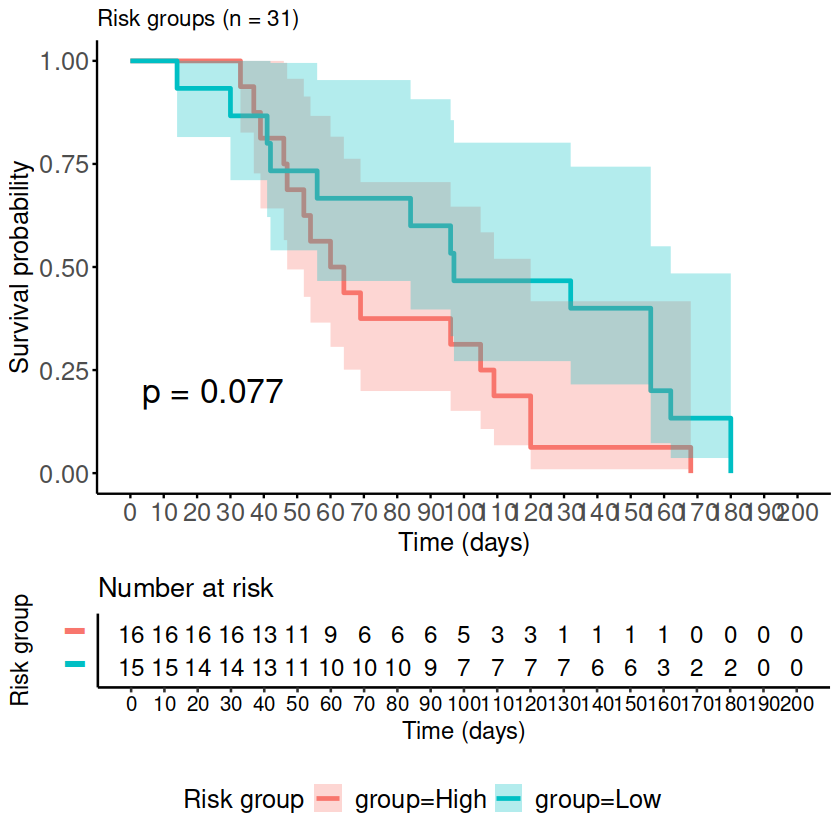

In [50]:
km.res.02